In [1]:
### Distance Matrix to MDS

### Get data

In [1]:
import pandas as pd
import numpy as np

In [5]:
### Import distance matrix and remove Row labels
df_1000 = pd.read_table("Data/ssRNA_complete_genomes_100_subsample_1000.dist")
df_1000 = df_1000.drop("#query", axis=1)
### Get filenames from headers
INDEX_1000 = list(df_1000)
print(len(INDEX_1000))

3900


In [8]:
### Import distance matrix and remove Row labels
df_50000 = pd.read_table("Data/ssRNA_complete_genomes_100_subsample_50000.dist")
df_50000 = df_50000.drop("#query", axis=1)
### Get filenames from headers
INDEX_50000 = list(df_50000)
print(len(INDEX_50000))

3900


### Get metadata

In [9]:
import pandas as pd
df_Accessions_100 = pd.read_csv("Data/df_ssRNA_complete_100_subsample.tsv", sep="\t")
len(df_Accessions_100)

3900

In [10]:
Acc_to_species = dict(zip(df_Accessions_100["accs"], df_Accessions_100["species"]))

In [13]:
from scipy.spatial.distance import squareform
def Get_per_species_distances_df(metaDF, distancesDF, INDEX):
    Species_dists={}
    for Species, Data in metaDF.groupby("species"):
        Accessions = Data["accs"]
        Positions = []
        for Acc in Accessions:
            Positions.append(INDEX.index(Acc))
        Submatrix = distancesDF.iloc[Positions, Positions]
        Values = squareform(Submatrix)
        Species_dists[Species] = Values
    return pd.DataFrame.from_dict(Species_dists)

In [14]:
df_Species_distances_1000 = Get_per_species_distances_df(df_Accessions_100, df_1000, INDEX_1000)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

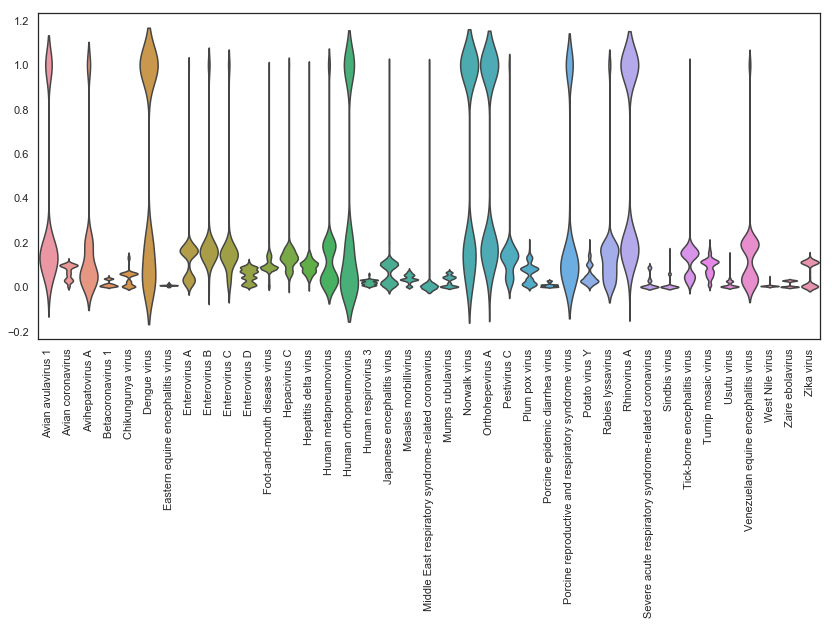

In [16]:
sns.set(rc={'figure.figsize':(14,6)})
sns.set_style("white")
dist_plt = sns.violinplot(
                data=df_Species_distances_1000,
                scale="width",
                width=0.9,
                inner=None
                )
plt.xticks(rotation=90)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_mash_1000_distances_violin.pdf')

In [17]:
df_Species_distances_50000 = Get_per_species_distances_df(df_Accessions_100, df_50000, INDEX_50000)

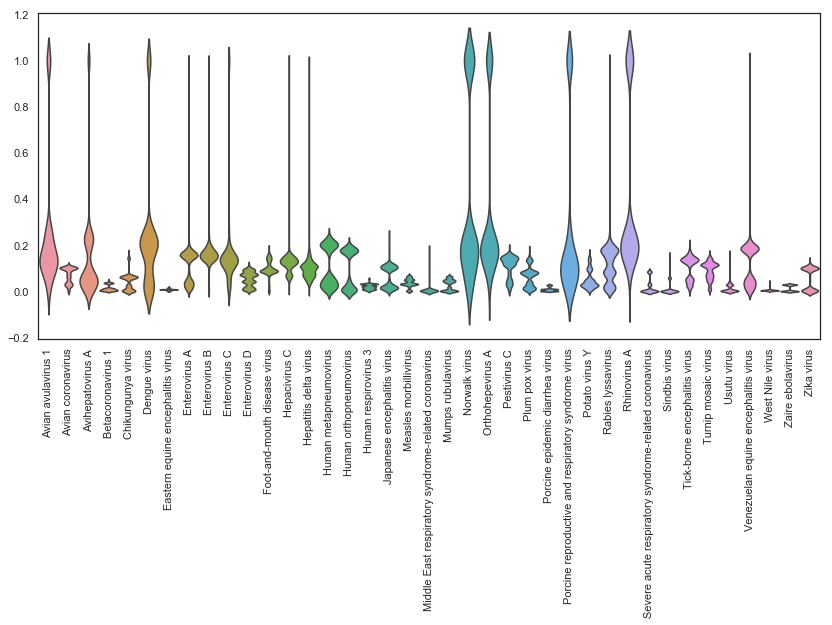

In [103]:
sns.set(rc={'figure.figsize':(14,6)})
sns.set_style("white")
dist_plt = sns.violinplot(
                data=df_Species_distances_50000,
                scale="width",
                width=0.9,
                inner=None
                )
plt.xticks(rotation=90)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_mash_50000_distances_violin.pdf')

In [19]:
df_Species_distances_1000 = df_Species_distances_1000.assign(Group='A')
df_Species_distances_50000 = df_Species_distances_50000.assign(Group='B')
All_df = pd.concat([df_Species_distances_1000, df_Species_distances_50000])

In [20]:
Exp_df = pd.melt(All_df, value_vars=list(All_df)[:-1], id_vars='Group')
Exp_df.head()

,Group,variable,value
0,A,Avian avulavirus 1,0.000344
1,A,Avian avulavirus 1,1.000000
2,A,Avian avulavirus 1,1.000000
3,A,Avian avulavirus 1,0.200503
4,A,Avian avulavirus 1,1.000000


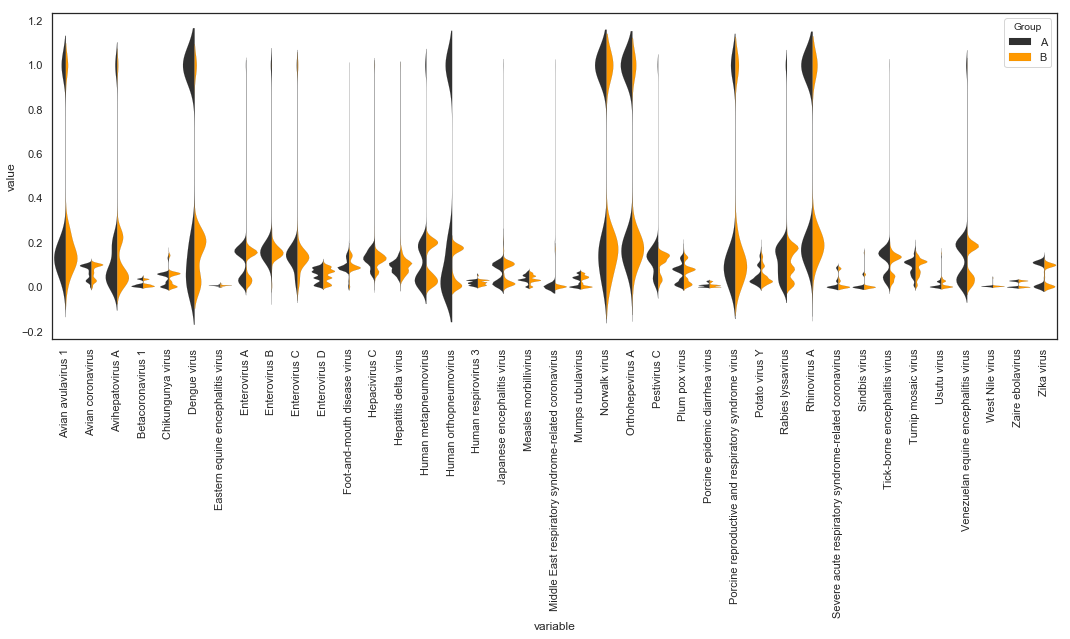

In [21]:
colors = ["#303030","#ff9900"]
sns.set(rc={'figure.figsize':(18,6)})
sns.set_style("white")
dist_plt = sns.violinplot(
                data=Exp_df,
                x="variable",
                y="value",
                scale="count",
                width=0.9,
                inner=None,
                split=True,
                hue="Group",
                palette=colors,
                linewidth=0.1,
                saturation=1
                )
plt.xticks(rotation=90)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_mash_1000_vs_50000_distances_violin.pdf')

### Break it down by groups

In [25]:
import pickle
# Load data (deserialize)
with open('Data/Dictionaries/Viral_lineage_dict.pkl', 'rb') as handle:
    Viral_lineage_dict = pickle.load(handle)
    
with open('Data/Dictionaries/Viral_parent_dict.pkl', 'rb') as handle:
    Viral_parent_dict = pickle.load(handle)
    
with open('Data/Dictionaries/Viral_sciname_dict.pkl', 'rb') as handle:
    Viral_sciname_dict = pickle.load(handle)
    
Viral_sciname_to_taxID = {y:x for x,y in Viral_sciname_dict.items()}

with open('Data/Dictionaries/Viral_taxID_to_rank_dict.pkl', 'rb') as handle:
    Viral_taxID_to_rank_dict = pickle.load(handle)

In [33]:
# df_Accessions_100["species_taxID"] = df_Accessions_100["species"].map(Viral_sciname_to_taxID)
# df_Accessions_100["genus_taxID"] = df_Accessions_100["species_taxID"].map(Viral_parent_dict)
# df_Accessions_100["genus"] = df_Accessions_100["genus_taxID"].map(Viral_sciname_dict)
# df_Accessions_100["family_taxID"] = df_Accessions_100["genus_taxID"].map(Viral_parent_dict)
# df_Accessions_100["family"] = df_Accessions_100["family_taxID"].map(Viral_sciname_dict)
df_Accessions_100["organism_taxID"] = df_Accessions_100["organism"].map(Viral_sciname_to_taxID)
df_Accessions_100["lineage"] = df_Accessions_100["organism_taxID"].map(Viral_lineage_dict)



In [98]:
def Get_per_organism_distances_df(metaDF, distancesDF, INDEX):
    Organism_dists={}
    for Organism, Data in metaDF.groupby("organism"):
        Accessions = Data["accs"]
        if len(Accessions) > 10:
            Positions = []
            for Acc in Accessions:
                Positions.append(INDEX.index(Acc))
            Submatrix = distancesDF.iloc[Positions, Positions]
            Values = squareform(Submatrix)
            Organism_dists[Organism] = Values
    for entry in Organism_dists:
        if len(Organism_dists[entry]) < 4950:
            a = Organism_dists[entry]
            Organism_dists[entry] = np.append(a, np.full([1, (4950 - len(Organism_dists[entry]))], np.nan)[0])

    df_Organism_dists = pd.DataFrame.from_dict(Organism_dists)
    return df_Organism_dists

In [99]:
df_organism_distances_1000 = Get_per_organism_distances_df(df_Accessions_100, df_1000, INDEX_1000)
print(len(df_organism_distances_1000))

4950


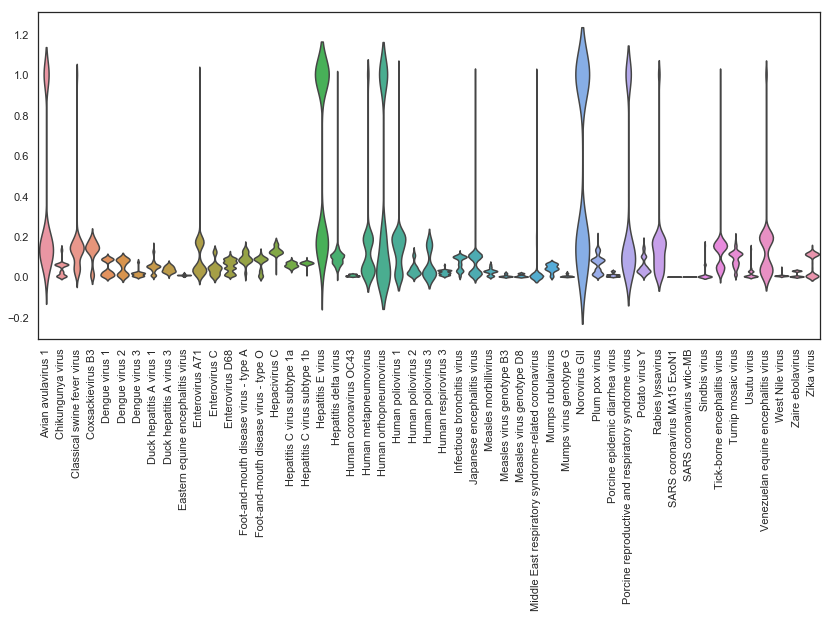

In [102]:
sns.set(rc={'figure.figsize':(14,6)})
sns.set_style("white")
dist_plt = sns.violinplot(
                data=df_organism_distances_1000,
                scale="width",
                width=0.9,
                inner=None
                )
plt.xticks(rotation=90)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_mash_1000_organism_distances_violin.pdf')

In [104]:
df_organism_distances_50000 = Get_per_organism_distances_df(df_Accessions_100, df_50000, INDEX_50000)
print(len(df_organism_distances_50000))

4950


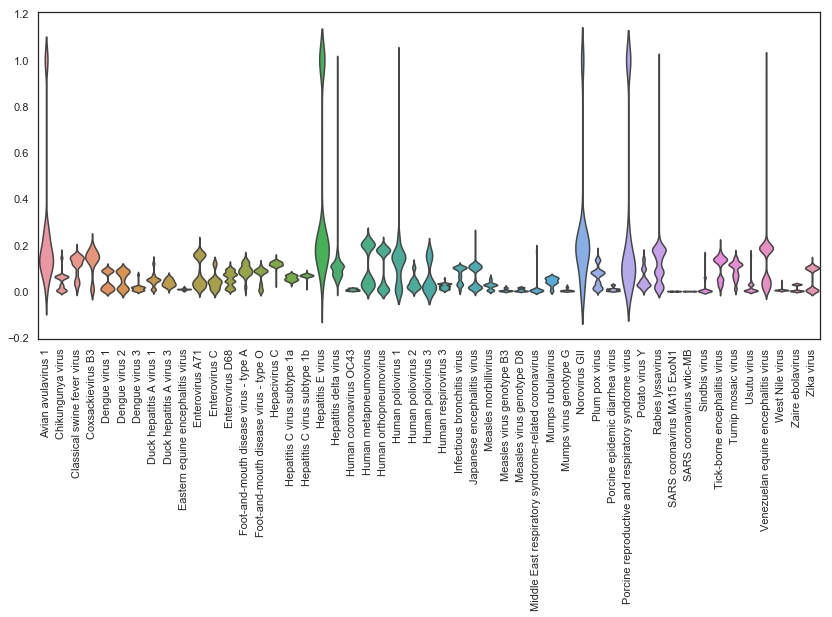

In [105]:
sns.set(rc={'figure.figsize':(14,6)})
sns.set_style("white")
dist_plt = sns.violinplot(
                data=df_organism_distances_50000,
                scale="width",
                width=0.9,
                inner=None
                )
plt.xticks(rotation=90)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_mash_50000_organism_distances_violin.pdf')

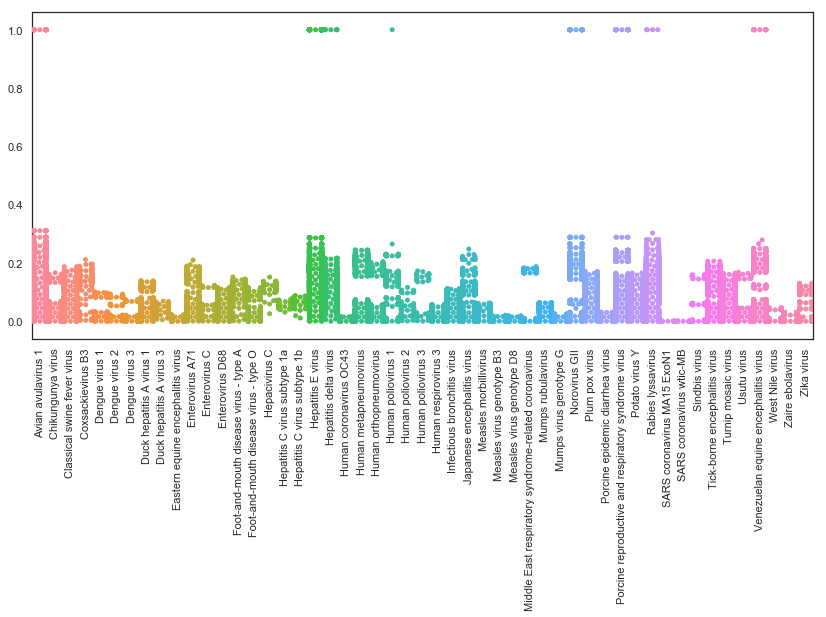

In [112]:
sns.set(rc={'figure.figsize':(14,6)})
sns.set_style("white")
dist_plt = sns.swarmplot(
                data=df_organism_distances_50000,
                )
plt.xticks(rotation=90)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_mash_50000_organism_distances_swarm.pdf')

In [107]:
df_organism_distances_1000 = df_organism_distances_1000.assign(Group='A')
df_organism_distances_50000 = df_organism_distances_50000.assign(Group='B')
All_df = pd.concat([df_organism_distances_1000, df_organism_distances_50000])
Exp_df2 = pd.melt(All_df, value_vars=list(All_df)[:-1], id_vars='Group')
Exp_df2.head()

,Group,variable,value
0,A,Avian avulavirus 1,0.000344
1,A,Avian avulavirus 1,1.000000
2,A,Avian avulavirus 1,1.000000
3,A,Avian avulavirus 1,0.200503
4,A,Avian avulavirus 1,1.000000


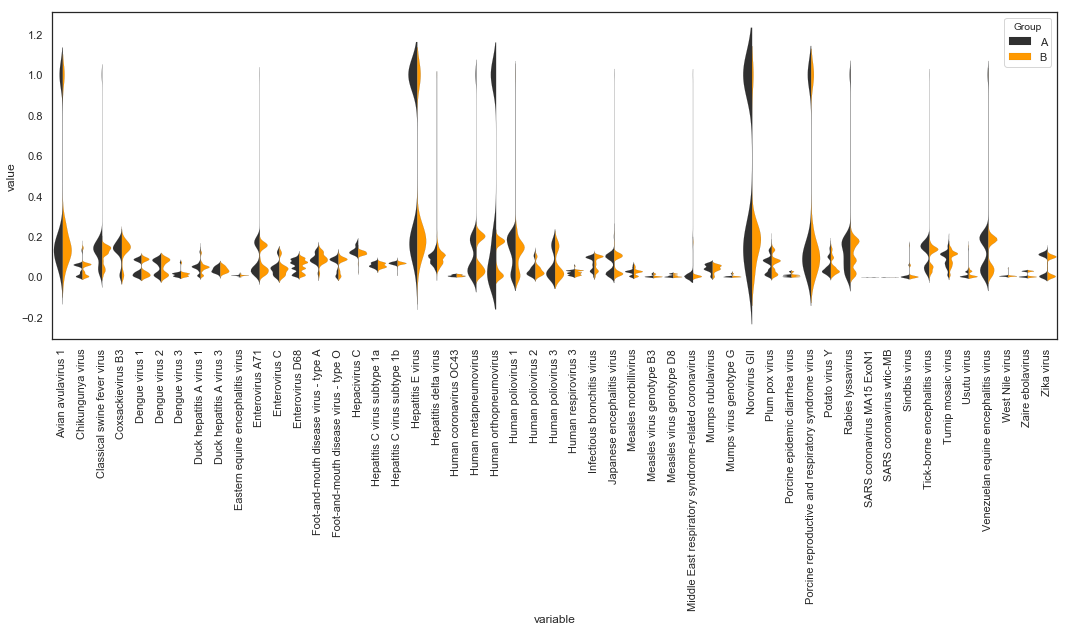

In [108]:
colors = ["#303030","#ff9900"]
sns.set(rc={'figure.figsize':(18,6)})
sns.set_style("white")
dist_plt = sns.violinplot(
                data=Exp_df2,
                x="variable",
                y="value",
                scale="count",
                width=0.9,
                inner=None,
                split=True,
                hue="Group",
                palette=colors,
                linewidth=0.1,
                saturation=1
                )
plt.xticks(rotation=90)
plt.savefig('Visualizations/ssRNA_complete_100_subsample_mash_1000_vs_50000_organism_distances_violin.pdf')

In [110]:
df_Accessions_100[df_Accessions_100["organism"] == "Human poliovirus 1"].head()

,Unnamed: 0,index,accs,source,description,seqlen,organism,division,date,biocategory,species,freq,species_taxID,genus_taxID,genus,family_taxID,family,lineage,organism_taxID
800,1415357,1415357,KJ170439.1,NEIGHBOR,"Human poliovirus 1 strain NIE1018354, complete...",7388,Human poliovirus 1,VRL,21-JUN-2016,EX,Enterovirus C,687,138950,12059,Enterovirus,12058,Picornaviridae,"12080,138950,12059,12058,464095,35278,439488,1...",12080
801,1415358,1415358,KJ170440.1,NEIGHBOR,"Human poliovirus 1 strain NIE1018360, complete...",7388,Human poliovirus 1,VRL,21-JUN-2016,EX,Enterovirus C,687,138950,12059,Enterovirus,12058,Picornaviridae,"12080,138950,12059,12058,464095,35278,439488,1...",12080
802,1415355,1415355,KJ170437.1,NEIGHBOR,"Human poliovirus 1 strain NIE1218351, complete...",7388,Human poliovirus 1,VRL,21-JUN-2016,EX,Enterovirus C,687,138950,12059,Enterovirus,12058,Picornaviridae,"12080,138950,12059,12058,464095,35278,439488,1...",12080
803,1415354,1415354,KJ170436.1,NEIGHBOR,"Human poliovirus 1 strain NIE1018316, complete...",7388,Human poliovirus 1,VRL,21-JUN-2016,EX,Enterovirus C,687,138950,12059,Enterovirus,12058,Picornaviridae,"12080,138950,12059,12058,464095,35278,439488,1...",12080
804,1415356,1415356,KJ170438.1,NEIGHBOR,"Human poliovirus 1 strain NIE1018319, complete...",7388,Human poliovirus 1,VRL,21-JUN-2016,EX,Enterovirus C,687,138950,12059,Enterovirus,12058,Picornaviridae,"12080,138950,12059,12058,464095,35278,439488,1...",12080
